In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
X = np.load('/content/drive/MyDrive/data/datasave/rolling_window_sequences.npy')
metadata = pd.read_csv('/content/drive/MyDrive/data/datasave/sequence_metadata_with_RUL.csv')
y = metadata['RUL'].values

print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

X Shape:  (17631, 30, 66)
y Shape:  (17631,)


In [5]:
# split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

#### LSTM Model Definition:
 - Input: (window_size, num_features)
 - Output: Single RUL value
 - Architecture: 1 LSTM layer + 1 Dense output layer
 - Hyperparameters: 64 units, 'tanh' activation, Adam optimizer, MSE loss

**Note:** For regression tasks, no activation on output layer

In [7]:
# LSTM Model for RUL Prediction
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training Setup: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

In [9]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)


Epoch 1/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11464.6484
Epoch 1: val_loss improved from inf to 8841.26074, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 11456.9209 - val_loss: 8841.2607 - learning_rate: 0.0010
Epoch 2/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8424.5547
Epoch 2: val_loss improved from 8841.26074 to 7168.93896, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 8420.3965 - val_loss: 7168.9390 - learning_rate: 0.0010
Epoch 3/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6872.7476
Epoch 3: val_loss improved from 7168.93896 to 5899.73389, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 6869.8232 - val_loss: 5899.7339 - learning_rate: 0.0010
Epoch 4/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5677.2856
Epoch 4: val_loss improved from 5899.73389 to 4892.68115, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━

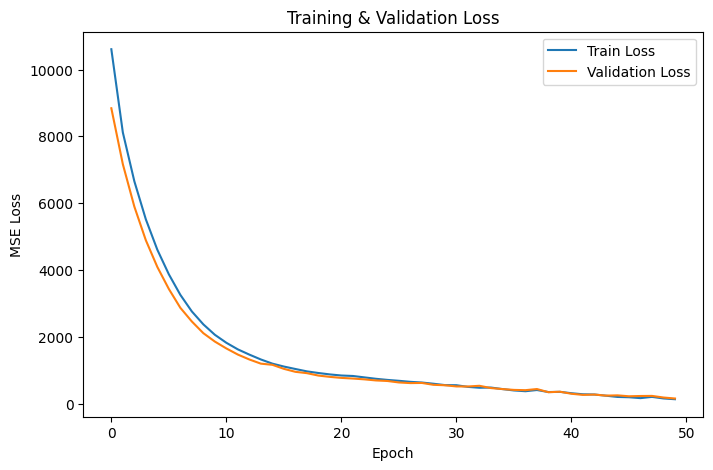

In [10]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


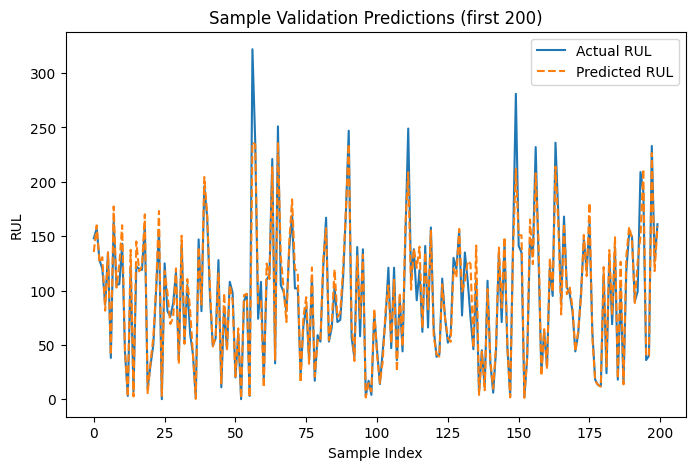

In [11]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()
